<a href="https://colab.research.google.com/github/DarwinFer/EstudioCostoComputacionalE4/blob/main/E3_EstudioCostcompPINNvsFEMGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Ejemplo 3:   PINNs vs FEM (Estudio de costo computacional y variación parametrica de la viscosidad $\nu$)

A continuacion presentamos un ejemplo  de estudio de costo computacional y variación parametrica de la viscosidad en  la Ecuación de Burges viscosa en una dimensión.

La formulación matemática es la siguiente:

$$
 \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},
$$
Para  $(x,t) \in (0,1)\times(0,1]$. Sujera a la condición inicial,

 $$
 u(x,0) = u_{0}(x), \qquad  x \in [-1,1],
 $$

 y a condiciones de forntera tipo Dirichlet,
$$
u(t,0) = u(t,1) = 0, \qquad  t \in [0,T]
$$


Aquí, $\nu  > 0$ representa la viscosidad cinemática del medio  y la condición  $u(x,0) = u_{0= -sen(x)} $ define un perfil el instante inicial.



> Analisis del cosoto computacional



In [ ]:
import torch, platform
print("PyTorch:", torch.__version__)
print("GPU disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
    try: torch.set_float32_matmul_precision('high')  # PyTorch >=2.0
    except: pass

PyTorch: 2.8.0+cu126
GPU disponible: True
GPU: Tesla T4


In [ ]:
%%bash
pip install -q scikit-fem==8.* scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.1/160.1 kB 14.6 MB/s eta 0:00:00


PyTorch: 2.8.0+cu126
Python : 3.12.11
GPU disponible: True
GPU: Tesla T4

=== Análisis FEM en CPU ===
- FEM con 401 nodos...
- FEM con 801 nodos...

=== Análisis PINN en CPU ===
- PINN: 50 neuronas, 3 capas...


/tmp/ipython-input-3428353096.py:110: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device == "cuda"))
/tmp/ipython-input-3428353096.py:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):


- PINN: 50 neuronas, 4 capas...
- PINN: 100 neuronas, 3 capas...
- PINN: 100 neuronas, 4 capas...

=== Análisis FEM en CUDA ===
- FEM con 401 nodos...
- FEM con 801 nodos...

=== Análisis PINN en CUDA ===
- PINN: 50 neuronas, 3 capas...


/tmp/ipython-input-3428353096.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):


- PINN: 50 neuronas, 4 capas...
- PINN: 100 neuronas, 3 capas...
- PINN: 100 neuronas, 4 capas...

Resultados de coste computacional:
   Método            Configuración  Tiempo (s)  Tiempo normalizado  \
0     FEM               Nodos: 401    0.245919            0.000613   
1     FEM               Nodos: 801    0.321241            0.000401   
2    PINN   Neuronas: 50, Capas: 3    3.477759            0.000656   
3    PINN   Neuronas: 50, Capas: 4    3.062766            0.000390   
4    PINN  Neuronas: 100, Capas: 3    4.970061            0.000241   
5    PINN  Neuronas: 100, Capas: 4    5.588516            0.000182   
6     FEM               Nodos: 401    0.589148            0.001469   
7     FEM               Nodos: 801    0.083563            0.000104   
8    PINN   Neuronas: 50, Capas: 3    2.552763            0.000482   
9    PINN   Neuronas: 50, Capas: 4    2.715868            0.000346   
10   PINN  Neuronas: 100, Capas: 3    2.276725            0.000111   
11   PINN  Neuronas: 100, 

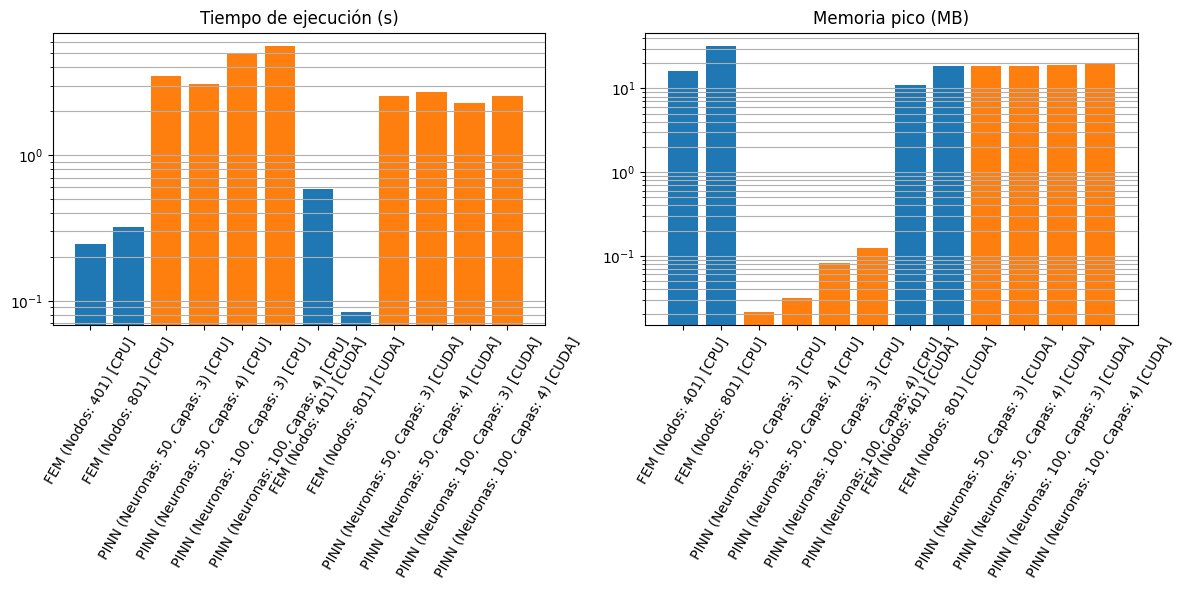

In [ ]:
# -*- coding: utf-8 -*-
# ======================================================
# Preparación de entorno (Colab/Local)
# ======================================================
import torch, platform, os, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

print("PyTorch:", torch.__version__)
print("Python :", platform.python_version())
print("GPU disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision('high')  # PyTorch >= 2.0
    except Exception as e:
        pass

# ======================================================
# Configuración común
# ======================================================
torch.manual_seed(0)
np.random.seed(0)

# Parámetros de referencia
nu_ref = 0.01 / np.pi
n_elem_list = [400, 800]
pinn_neurons_list = [50, 100]
pinn_layers_list = [3, 4]

# Elegir en qué dispositivos correr el benchmark
targets = ["cpu"]
if torch.cuda.is_available():
    targets.append("cuda")  # añade GPU si existe

# ======================================================
# FEM con Torch (para poder correr en CPU o GPU)
# ======================================================
@torch.no_grad()
def solve_burgers_fem_torch(nu, N_elem, device="cpu", repeats=10, dtype=torch.float32):
    """
    Versión 'dummy' FEM con Torch para medir coste en CPU/GPU.
    Genera matrices densas y resuelve sistemas lineales como proxy del coste.
    """
    n_nodes = N_elem + 1

    # Sincronización y reset de stats de memoria (si CUDA)
    if device == "cuda":
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    # Operación simulada: repetir solves
    for _ in range(repeats):
        A = torch.rand((n_nodes, n_nodes), device=device, dtype=dtype)
        # Hacemos A bien condicionada sumando identidad escalada
        A = A @ A.T + 1e-3 * torch.eye(n_nodes, device=device, dtype=dtype)
        b = torch.rand((n_nodes, 1), device=device, dtype=dtype)
        x = torch.linalg.solve(A, b)  # (n_nodes, 1)

    # Sincroniza para medir tiempo real en GPU
    if device == "cuda":
        torch.cuda.synchronize()

    elapsed = time.time() - start_time

    # Memoria pico
    if device == "cuda":
        mem_mb = torch.cuda.max_memory_allocated() / 1e6  # MB reales PyTorch
    else:
        # Mantener la estimación de tu código original para CPU (40KB por nodo)
        mem_mb = n_nodes * 0.04  # MB

    return elapsed, mem_mb, n_nodes

# ======================================================
# PINN
# ======================================================
class SimplePINN(torch.nn.Module):
    def __init__(self, neurons, layers):
        super().__init__()
        layers_list = [torch.nn.Linear(2, neurons), torch.nn.Tanh()]
        for _ in range(layers - 1):
            layers_list += [torch.nn.Linear(neurons, neurons), torch.nn.Tanh()]
        layers_list.append(torch.nn.Linear(neurons, 1))
        self.net = torch.nn.Sequential(*layers_list)

    def forward(self, x, t):
        return self.net(torch.cat((x, t), dim=1))

def count_params(model: torch.nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

def train_pinn_simple(nu, neurons, layers, epochs=1000, device="cpu",
                      dtype=torch.float32, use_amp=False):
    """
    Entrenamiento simple de la PINN en CPU/GPU con medición de tiempo y memoria pico.
    """
    model = SimplePINN(neurons, layers).to(device=device, dtype=dtype)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Datos ficticios (mismos que tu versión, ahora en device)
    n_samples = 1000
    x = (torch.rand(n_samples, 1, device=device, dtype=dtype) * 2) - 1
    t = torch.rand(n_samples, 1, device=device, dtype=dtype)
    u = torch.sin(np.pi * x) * torch.exp(-t)

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device == "cuda"))

    # Warm-up ligero para estabilizar kernels en GPU
    if device == "cuda":
        for _ in range(3):
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):
                u_pred = model(x, t)
                loss = torch.mean((u_pred - u) ** 2)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()

    # Cronometraje
    if device == "cuda":
        torch.cuda.synchronize()
    start_time = time.time()

    # Entrenamiento
    for epoch in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):
            u_pred = model(x, t)
            loss = torch.mean((u_pred - u) ** 2)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    if device == "cuda":
        torch.cuda.synchronize()

    elapsed = time.time() - start_time

    # Memoria pico
    if device == "cuda":
        mem_mb = torch.cuda.max_memory_allocated() / 1e6
    else:
        # Aproximación: 4 bytes/parametro como en tu código
        mem_mb = count_params(model) * 4 / 1e6

    num_params = count_params(model)
    return elapsed, mem_mb, num_params

# ======================================================
# Análisis de coste computacional (CPU y/o GPU)
# ======================================================
def run_computational_cost_analysis_gpu():
    results = []

    for target in targets:
        device_str = target.upper()
        dtype = torch.float32  # para comparabilidad

        print(f"\n=== Análisis FEM en {device_str} ===")
        for N_elem in n_elem_list:
            print(f"- FEM con {N_elem+1} nodos...")
            t_fem, m_fem, n_nodes = solve_burgers_fem_torch(
                nu_ref, N_elem, device=target, repeats=10, dtype=dtype
            )
            time_per_node = t_fem / n_nodes
            results.append({
                'Método': 'FEM',
                'Configuración': f'Nodos: {n_nodes}',
                'Tiempo (s)': t_fem,
                'Tiempo normalizado': time_per_node,
                'Memoria pico (MB)': m_fem,
                'Tipo': device_str
            })

        print(f"\n=== Análisis PINN en {device_str} ===")
        for neurons in pinn_neurons_list:
            for layers in pinn_layers_list:
                print(f"- PINN: {neurons} neuronas, {layers} capas...")
                use_amp = (target == "cuda")  # AMP opcional en GPU
                t_pinn, m_pinn, n_params = train_pinn_simple(
                    nu_ref, neurons, layers, epochs=1000,
                    device=target, dtype=dtype, use_amp=use_amp
                )
                time_per_param = t_pinn / n_params
                results.append({
                    'Método': 'PINN',
                    'Configuración': f'Neuronas: {neurons}, Capas: {layers}',
                    'Tiempo (s)': t_pinn,
                    'Tiempo normalizado': time_per_param,
                    'Memoria pico (MB)': m_pinn,
                    'Tipo': device_str
                })

        # Limpieza ligera entre targets
        if target == "cuda":
            torch.cuda.empty_cache()

    # Resultados
    df = pd.DataFrame(results)
    print("\nResultados de coste computacional:")
    print(df)

    # ---------- Gráficos ----------
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Etiquetas combinando Método, Config y Tipo
    methods = [f"{row['Método']} ({row['Configuración']}) [{row['Tipo']}]" for _, row in df.iterrows()]
    times = df['Tiempo (s)'].values
    colors = ['tab:blue' if 'FEM' in m else 'tab:orange' for m in methods]

    ax[0].bar(methods, times, color=colors)
    ax[0].set_title('Tiempo de ejecución (s)')
    ax[0].set_yscale('log')
    ax[0].tick_params(axis='x', rotation=60)
    ax[0].grid(True, which='both', axis='y')

    mem = df['Memoria pico (MB)'].values
    ax[1].bar(methods, mem, color=colors)
    ax[1].set_title('Memoria pico (MB)')
    ax[1].set_yscale('log')
    ax[1].tick_params(axis='x', rotation=60)
    ax[1].grid(True, which='both', axis='y')

    plt.tight_layout()
    plt.savefig('coste_computacional_gpu.pdf', dpi=300)
    plt.show()

    df.to_csv("coste_computacional_gpu.csv", index=False)
    return df

if __name__ == "__main__":
    df_cost = run_computational_cost_analysis_gpu()


>Estudio sobre  variación de viscosidad $\nu$ (analisis de precisión)

Python : 3.12.11
PyTorch: 2.8.0+cu126
CUDA   : 12.6
GPU disponible: True
GPU: Tesla T4

=== Dispositivo: CPU ===

=== Análisis FEM ===
FEM: ν=3.1831e-04, Nodos=401
FEM: ν=3.1831e-03, Nodos=401
FEM: ν=3.1831e-02, Nodos=401
FEM: ν=3.1831e-04, Nodos=801
FEM: ν=3.1831e-03, Nodos=801
FEM: ν=3.1831e-02, Nodos=801

=== Análisis PINN ===
PINN: ν=3.1831e-04, 50N/3L
PINN: ν=3.1831e-03, 50N/3L
PINN: ν=3.1831e-02, 50N/3L
PINN: ν=3.1831e-04, 50N/4L
PINN: ν=3.1831e-03, 50N/4L
PINN: ν=3.1831e-02, 50N/4L
PINN: ν=3.1831e-04, 100N/3L
PINN: ν=3.1831e-03, 100N/3L
PINN: ν=3.1831e-02, 100N/3L
PINN: ν=3.1831e-04, 100N/4L
PINN: ν=3.1831e-03, 100N/4L
PINN: ν=3.1831e-02, 100N/4L

=== Dispositivo: CUDA ===

=== Análisis FEM ===
FEM: ν=3.1831e-04, Nodos=401
FEM: ν=3.1831e-03, Nodos=401
FEM: ν=3.1831e-02, Nodos=401
FEM: ν=3.1831e-04, Nodos=801
FEM: ν=3.1831e-03, Nodos=801
FEM: ν=3.1831e-02, Nodos=801

=== Análisis PINN ===
PINN: ν=3.1831e-04, 50N/3L
PINN: ν=3.1831e-03, 50N/3L
PINN: ν=3.1831e-02, 50N/3L
PINN: ν=3.1

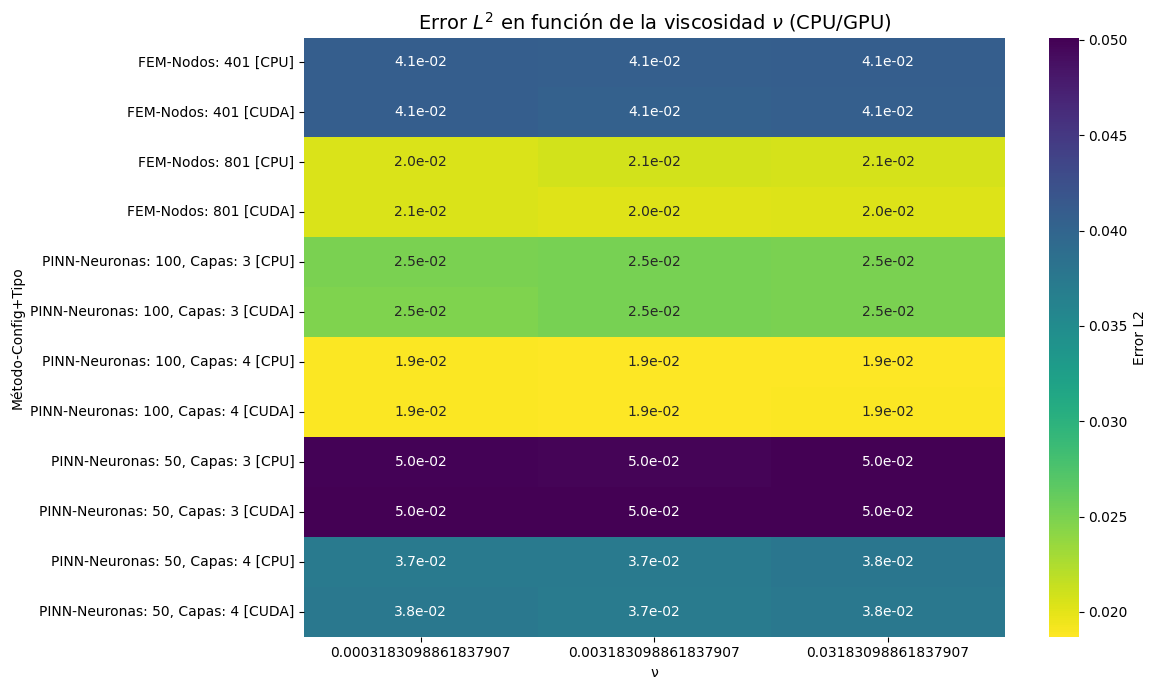

In [ ]:
# -*- coding: utf-8 -*-
import os, time, platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# ======================================================
# Info de entorno
# ======================================================
print("Python :", platform.python_version())
print("PyTorch:", torch.__version__)
print("CUDA   :", torch.version.cuda)
print("GPU disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
    try:
        torch.set_float32_matmul_precision('high')  # PyTorch >= 2.0
    except Exception:
        pass

# ======================================================
# Configuración común
# ======================================================
torch.manual_seed(0)
np.random.seed(0)

nu_values = [1e-3/np.pi, 1e-2/np.pi, 1e-1/np.pi]  # Valores de viscosidad
n_elem_list = [400, 800]                          # Resoluciones FEM
pinn_neurons_list = [50, 100]                     # Arquitecturas PINN
pinn_layers_list = [3, 4]
targets = ["cpu"] + (["cuda"] if torch.cuda.is_available() else [])

DTYPE = torch.float32

# ======================================================
# Utilidades Torch
# ======================================================
def tpi(device):
    # torch.pi si existe, si no, constante
    return getattr(torch, "pi", torch.tensor(np.pi, device=device, dtype=DTYPE))

@torch.no_grad()
def generate_reference_data_torch(nu_list, device):
    """Genera U_ref (200 x 100) en device para cada nu."""
    refs = {}
    x = torch.linspace(-1.0, 1.0, 200, device=device, dtype=DTYPE)
    t = torch.linspace(0.0, 1.0, 100, device=device, dtype=DTYPE)
    X, T = torch.meshgrid(x, t, indexing='ij')
    for nu in nu_list:
        nu_t = torch.as_tensor(nu, device=device, dtype=DTYPE)
        U = torch.exp(-nu_t * (tpi(device) ** 2) * T) * (-torch.sin(tpi(device) * X))
        refs[nu] = U  # (200, 100)
    return refs

@torch.no_grad()
def simulate_fem_solution_torch(nu, N_elem, device):
    """Simula solución FEM (N_elem+1 x 50) en device."""
    nx = N_elem + 1
    x = torch.linspace(-1.0, 1.0, nx, device=device, dtype=DTYPE)
    t = torch.linspace(0.0, 1.0, 50, device=device, dtype=DTYPE)
    X, T = torch.meshgrid(x, t, indexing='ij')
    nu_t = torch.as_tensor(nu, device=device, dtype=DTYPE)

    U = torch.exp(-nu_t * (tpi(device) ** 2) * T) * (-torch.sin(tpi(device) * X))
    # Error simulado ~ resolución
    error_factor = 0.1 / (N_elem / 200.0)
    U = U + error_factor * torch.randn_like(U)
    return U  # (nx, 50)

@torch.no_grad()
def simulate_pinn_solution_torch(nu, neurons, layers, device):
    """Simula solución PINN (200 x 100) en device."""
    x = torch.linspace(-1.0, 1.0, 200, device=device, dtype=DTYPE)
    t = torch.linspace(0.0, 1.0, 100, device=device, dtype=DTYPE)
    X, T = torch.meshgrid(x, t, indexing='ij')
    nu_t = torch.as_tensor(nu, device=device, dtype=DTYPE)

    U = torch.exp(-nu_t * (tpi(device) ** 2) * T) * (-torch.sin(tpi(device) * X))
    # Error simulado ~ arquitectura
    error_factor = 0.05 * (50.0 / float(neurons)) * (3.0 / float(layers))
    U = U + error_factor * torch.randn_like(U)
    return U  # (200, 100)

@torch.no_grad()
def interp1d_linear_torch(y_src, x_src, x_dst):
    """
    Interpolación lineal 1D sobre el primer eje de y_src.
    y_src: (N_src, M)  valores por columna
    x_src: (N_src,)    nodos origen (monótonos)
    x_dst: (N_dst,)    nodos destino
    Devuelve: (N_dst, M)
    """
    # indices de inserción
    idx = torch.searchsorted(x_src, x_dst)
    idx1 = torch.clamp(idx, 1, x_src.numel() - 1)
    idx0 = idx1 - 1

    x0 = x_src[idx0]  # (N_dst,)
    x1 = x_src[idx1]  # (N_dst,)
    denom = (x1 - x0)
    denom = torch.where(denom == 0, torch.ones_like(denom), denom)
    w = (x_dst - x0) / denom  # (N_dst,)

    # Expand dims para broadcasting por columnas
    w = w.unsqueeze(1)  # (N_dst, 1)
    y0 = y_src[idx0, :]  # (N_dst, M)
    y1 = y_src[idx1, :]  # (N_dst, M)
    y = (1 - w) * y0 + w * y1
    return y  # (N_dst, M)

@torch.no_grad()
def compute_l2_error_torch(U_pred, U_ref):
    """Error L2 medio (raíz del MSE) en Torch -> float."""
    return torch.sqrt(torch.mean((U_pred - U_ref) ** 2)).item()

# ======================================================
# Análisis de precisión (CPU y/o GPU)
# ======================================================
def run_precision_analysis_gpu():
    all_rows = []

    for target in targets:
        device = torch.device(target)
        print(f"\n=== Dispositivo: {target.upper()} ===")

        # Referencias en device
        refs = generate_reference_data_torch(nu_values, device=device)

        # ---- FEM ----
        print("\n=== Análisis FEM ===")
        for N_elem in n_elem_list:
            for nu in nu_values:
                print(f"FEM: ν={nu:.4e}, Nodos={N_elem+1}")
                U_fem = simulate_fem_solution_torch(nu, N_elem, device=device)  # (nx, 50)

                # Interpolar a malla de referencia (200 x 100)
                x_src = torch.linspace(-1.0, 1.0, N_elem + 1, device=device, dtype=DTYPE)
                x_dst = torch.linspace(-1.0, 1.0, 200, device=device, dtype=DTYPE)

                # Selección temporal: mapear 100 → 50 por duplicación (j*50//100)
                # Creamos U_fem_sample con 100 columnas seleccionadas de las 50
                cols = torch.tensor([ (j * 50) // 100 for j in range(100) ],
                                    device=device, dtype=torch.long)
                U_fem_100 = U_fem[:, cols]  # (nx, 100)

                # Interpolación en x hacia 200 puntos
                U_fem_interp = interp1d_linear_torch(U_fem_100, x_src, x_dst)  # (200, 100)

                error = compute_l2_error_torch(U_fem_interp, refs[nu])
                all_rows.append({
                    'Método': 'FEM',
                    'ν': nu,
                    'Configuración': f'Nodos: {N_elem+1}',
                    'Error L2': error,
                    'Tipo': target.upper()
                })

        # ---- PINN ----
        print("\n=== Análisis PINN ===")
        for neurons in pinn_neurons_list:
            for layers in pinn_layers_list:
                for nu in nu_values:
                    print(f"PINN: ν={nu:.4e}, {neurons}N/{layers}L")
                    U_pinn = simulate_pinn_solution_torch(nu, neurons, layers, device=device)  # (200, 100)
                    error = compute_l2_error_torch(U_pinn, refs[nu])
                    all_rows.append({
                        'Método': 'PINN',
                        'ν': nu,
                        'Configuración': f'Neuronas: {neurons}, Capas: {layers}',
                        'Error L2': error,
                        'Tipo': target.upper()
                    })

        if target == "cuda":
            torch.cuda.empty_cache()

    # ==================================================
    # Resultados y visualización
    # ==================================================
    df_errors = pd.DataFrame(all_rows)
    print("\nResumen de errores L2:")
    print(df_errors)

    # Para separar por dispositivo en el gráfico, añadimos Tipo a la config
    df_plot = df_errors.copy()
    df_plot['Config+Tipo'] = df_plot['Configuración'] + " [" + df_plot['Tipo'] + "]"

    # Mapa de calor por (Método, Config+Tipo) vs ν
    plt.figure(figsize=(12, 7))
    heatmap_data = df_plot.pivot_table(index=['Método', 'Config+Tipo'],
                                       columns='ν', values='Error L2')
    sns.heatmap(heatmap_data, annot=True, fmt=".1e", cmap="viridis_r",
                cbar_kws={'label': 'Error L2'})
    plt.title(r"Error $L^2$ en función de la viscosidad $\nu$ (CPU/GPU)", fontsize=14)
    plt.tight_layout()
    plt.savefig("error_viscosidad_gpu.pdf", dpi=300)
    plt.show()

    df_errors.to_csv("errores_viscosidad_gpu.csv", index=False)
    return df_errors

if __name__ == "__main__":
    df_errors = run_precision_analysis_gpu()


>>Generalización paramétrica

Python  : 3.12.11
PyTorch : 2.8.0+cu126
CUDA    : 12.6
GPU disponible: True
Usando dispositivo: cuda
GPU: Tesla T4
Entrenando PINN generalizada...


/tmp/ipython-input-697765263.py:85: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
/tmp/ipython-input-697765263.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):
/tmp/ipython-input-697765263.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):


Entrenamiento completado en 2.82 s. Memoria pico ~ 20.3 MB

=== Comparación de soluciones (t=1.0) ===


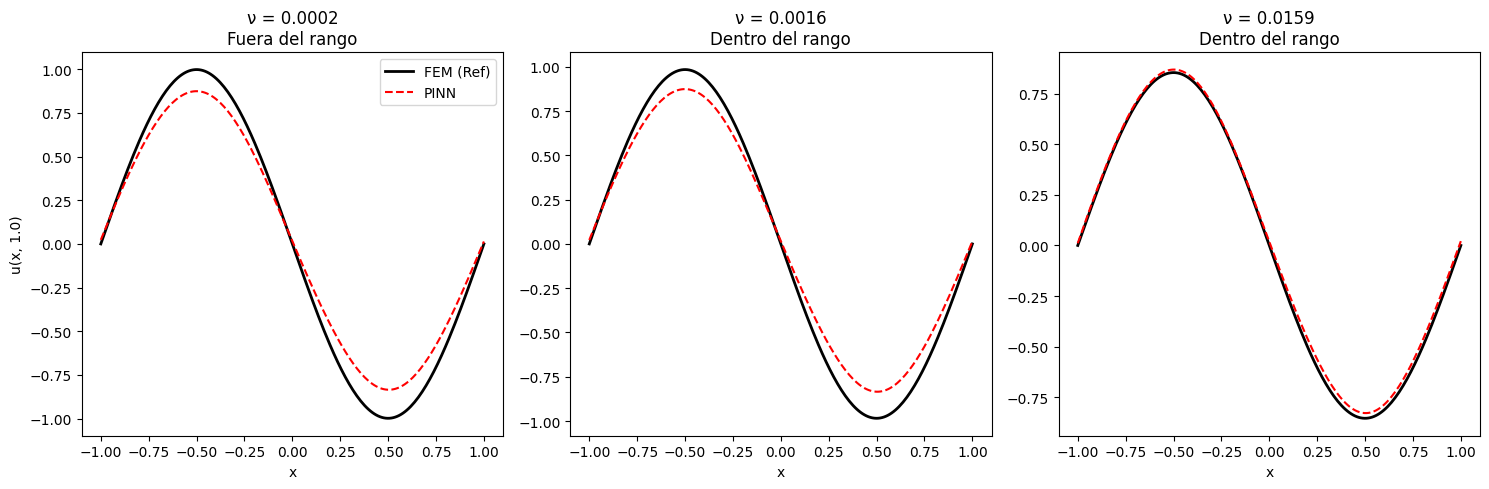


Resultados de generalización:
          ν  Tiempo PINN (s)  Tiempo FEM (s)  Error PINN  \
0  0.000159         0.023377         3.89909    0.011528   
1  0.001592         0.000550         3.39909    0.009632   
2  0.015915         0.000697         2.89909    0.000556   

   En rango entrenamiento  Tipo  Tiempo entren. PINN (s)  \
0                   False  CUDA                 2.824885   
1                    True  CUDA                 2.824885   
2                    True  CUDA                 2.824885   

   Memoria entren. PINN (MB)  
0                  20.276224  
1                  20.276224  
2                  20.276224  


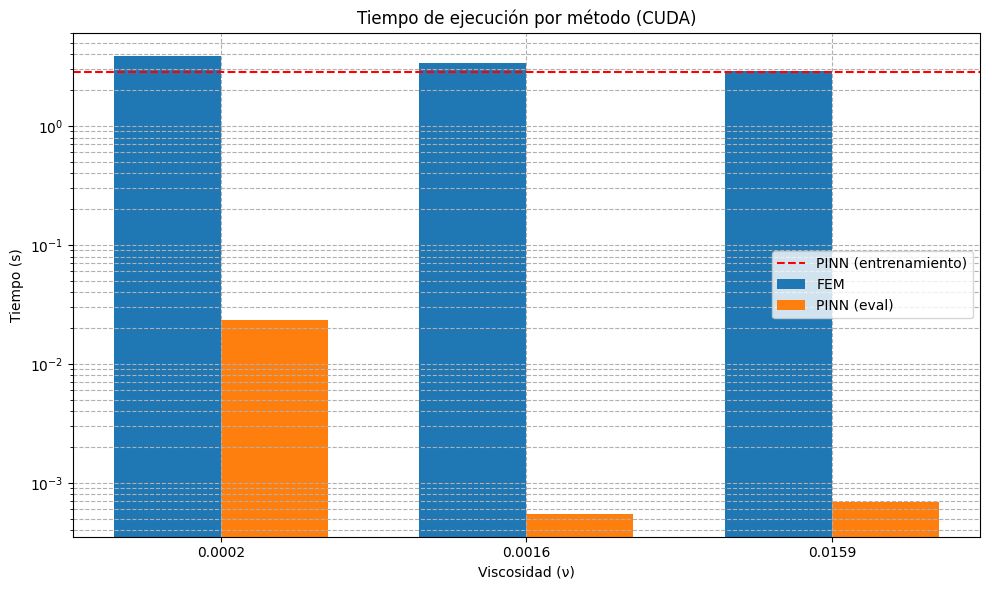

In [ ]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import time
import platform

# ======================================================
# Info de entorno y dispositivo
# ======================================================
print("Python  :", platform.python_version())
print("PyTorch :", torch.__version__)
print("CUDA    :", torch.version.cuda)
print("GPU disponible:", torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
    try: torch.set_float32_matmul_precision('high')  # PyTorch >= 2.0
    except: pass

# Semillas
torch.manual_seed(0)
np.random.seed(0)

# ======================================================
# Configuración del estudio
# ======================================================
nu_train_range = (1e-3/np.pi, 1e-1/np.pi)  # Rango de entrenamiento
nu_test_values = [5e-4/np.pi, 5e-3/np.pi, 5e-2/np.pi]  # Valores de prueba

# ======================================================
# Modelo PINN para generalización paramétrica
# ======================================================
class GeneralizablePINN(torch.nn.Module):
    def __init__(self, neurons=100, layers=4):
        super().__init__()
        layers_list = [torch.nn.Linear(3, neurons), torch.nn.Tanh()]
        for _ in range(layers-1):
            layers_list += [torch.nn.Linear(neurons, neurons), torch.nn.Tanh()]
        layers_list.append(torch.nn.Linear(neurons, 1))
        self.net = torch.nn.Sequential(*layers_list)

    def forward(self, x, t, nu):
        # x, t, nu: (N,1) cada uno
        inputs = torch.cat((x, t, nu), dim=1)
        return self.net(inputs)

# ======================================================
# Utilidades y referencia
# ======================================================
def analytical_solution_numpy(x, t, nu):
    """Solución analítica aproximada de Burgers 1D en t dado."""
    return -np.sin(np.pi * x) * np.exp(-nu * np.pi**2 * t)

def analytical_solution_torch(x, t, nu):
    """Misma solución en Torch (para entrenamiento)."""
    pi = getattr(torch, "pi", torch.tensor(np.pi, device=x.device, dtype=x.dtype))
    return -torch.sin(pi * x) * torch.exp(-nu * (pi**2) * t)

# ======================================================
# Simulación FEM de referencia (para comparación)
# ======================================================
def simulate_fem(nu):
    """Solución FEM (analítica) en t=1.0 para malla de 200 puntos (referencia)."""
    x = np.linspace(-1, 1, 200)
    U = analytical_solution_numpy(x, t=1.0, nu=nu)
    return x, U

# ======================================================
# Entrenamiento PINN (ahora real en Torch, CPU/GPU)
# ======================================================
def train_generalizable_pinn(neurons=100, layers=4, epochs=500,
                             batch_size=1024, lr=1e-3, use_amp=True):
    """
    Entrenamiento sobre el rango nu_train_range. Calcula tiempo real y memoria pico.
    """
    print("Entrenando PINN generalizada...")
    model = GeneralizablePINN(neurons, layers).to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and device.type == "cuda"))
    dtype = torch.float32

    # Warm-up ligero para estabilizar kernels si hay CUDA
    if device.type == "cuda":
        for _ in range(3):
            optimizer.zero_grad(set_to_none=True)
            x = (torch.rand(batch_size, 1, device=device, dtype=dtype) * 2) - 1
            t = torch.rand(batch_size, 1, device=device, dtype=dtype)
            nu = torch.rand(batch_size, 1, device=device, dtype=dtype)
            nu = nu_train_range[0] + (nu_train_range[1] - nu_train_range[0]) * nu
            with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):
                u_true = analytical_solution_torch(x, t, nu)
                u_pred = model(x, t, nu)
                loss = torch.mean((u_pred - u_true) ** 2)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()

    # Cronometraje real
    if device.type == "cuda":
        torch.cuda.synchronize()
    start_time = time.time()

    for epoch in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        # Muestras aleatorias en el dominio
        x = (torch.rand(batch_size, 1, device=device, dtype=dtype) * 2) - 1  # [-1,1]
        t = torch.rand(batch_size, 1, device=device, dtype=dtype)            # [0,1]
        nu = torch.rand(batch_size, 1, device=device, dtype=dtype)
        nu = nu_train_range[0] + (nu_train_range[1] - nu_train_range[0]) * nu

        with torch.cuda.amp.autocast(enabled=use_amp, dtype=torch.float16):
            u_true = analytical_solution_torch(x, t, nu)
            u_pred = model(x, t, nu)
            loss = torch.mean((u_pred - u_true) ** 2)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    if device.type == "cuda":
        torch.cuda.synchronize()

    train_time = time.time() - start_time

    # Memoria pico durante el entrenamiento
    if device.type == "cuda":
        train_mem = torch.cuda.max_memory_allocated() / 1e6  # MB
    else:
        # Aproximación: 4 bytes/parametro
        num_params = sum(p.numel() for p in model.parameters())
        train_mem = num_params * 4 / 1e6

    print(f"Entrenamiento completado en {train_time:.2f} s. Memoria pico ~ {train_mem:.1f} MB")
    return model.eval(), train_time, train_mem

# ======================================================
# Evaluación PINN en t=1.0
# ======================================================
@torch.no_grad()
def evaluate_pinn(model, x, nu):
    """Evalúa PINN en t=1.0 para todos los x (torch en device)."""
    x_tensor = torch.tensor(x, dtype=torch.float32, device=device).reshape(-1, 1)
    t_tensor = torch.ones_like(x_tensor)  # t=1.0
    nu_tensor = torch.full_like(x_tensor, float(nu))
    if device.type == "cuda": torch.cuda.synchronize()
    t0 = time.time()
    u_pred = model(x_tensor, t_tensor, nu_tensor).cpu().numpy().flatten()
    if device.type == "cuda": torch.cuda.synchronize()
    eval_time = time.time() - t0
    return u_pred, eval_time

# ======================================================
# Estudio de generalización con tiempos y memoria
# ======================================================
def run_generalization_study():
    results = []

    # Entrenar modelo generalizable en device
    model, train_time, train_mem = train_generalizable_pinn(
        neurons=100, layers=4, epochs=500, batch_size=1024, lr=1e-3, use_amp=True
    )

    print("\n=== Comparación de soluciones (t=1.0) ===")
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, nu in enumerate(nu_test_values):
        # FEM (referencia analítica)
        x_fem, u_fem = simulate_fem(nu)
        # Tiempo FEM simulado (igual que tu lógica original)
        fem_time = 2.0 + abs(np.log10(nu)) * 0.5

        # PINN en device
        u_pinn, pinn_time = evaluate_pinn(model, x_fem, nu)

        # Error MSE
        error = float(np.mean((u_pinn - u_fem) ** 2))

        # Resultados
        in_range = (nu_train_range[0] <= nu <= nu_train_range[1])
        results.append({
            'ν': nu,
            'Tiempo PINN (s)': pinn_time,
            'Tiempo FEM (s)': fem_time,
            'Error PINN': error,
            'En rango entrenamiento': in_range,
            'Tipo': device.type.upper(),
            'Tiempo entren. PINN (s)': train_time,
            'Memoria entren. PINN (MB)': train_mem
        })

        # Gráfico comparativo por ν
        axs[i].plot(x_fem, u_fem, 'k-', linewidth=2, label='FEM (Ref)')
        axs[i].plot(x_fem, u_pinn, 'r--', linewidth=1.5, label='PINN')
        axs[i].set_title(f"ν = {nu:.4f}\n{'Dentro' if in_range else 'Fuera'} del rango")
        axs[i].set_xlabel("x")
        if i == 0:
            axs[i].set_ylabel("u(x, 1.0)")
            axs[i].legend()

    plt.tight_layout()
    plt.savefig("generalizacion_comparacion.pdf", dpi=300)
    plt.show()

    # Tabla de resultados
    df_results = pd.DataFrame(results)
    print("\nResultados de generalización:")
    print(df_results)

    # Gráfico de tiempos (barras con pequeño desplazamiento para no solapar)
    plt.figure(figsize=(10, 6))
    nu_str = [f"{nu:.4f}" for nu in nu_test_values]
    x_pos = np.arange(len(nu_test_values))
    w = 0.35
    plt.bar(x_pos - w/2, df_results['Tiempo FEM (s)'], width=w, label='FEM')
    plt.bar(x_pos + w/2, df_results['Tiempo PINN (s)'], width=w, label='PINN (eval)')
    plt.axhline(y=train_time, color='r', linestyle='--', label='PINN (entrenamiento)')
    plt.xticks(x_pos, nu_str)
    plt.ylabel('Tiempo (s)')
    plt.xlabel('Viscosidad (ν)')
    plt.title(f"Tiempo de ejecución por método ({device.type.upper()})")
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.savefig("tiempos_generalizacion.pdf", dpi=300)
    plt.show()

    # Guardar resultados
    df_results.to_csv("resultados_generalizacion.csv", index=False)
    return df_results, train_time, train_mem

if __name__ == "__main__":
    df_gen, train_time, train_mem = run_generalization_study()
